In [1]:
import pandas as pd
import numpy as np

In [2]:
from dist import compute_AE_tanimoto_distance, compute_augmented_graph_distance
from dist import compute_embed3d_distance, hop_matrix_from_mol

## 1. Building High-Dimensional Probabilities (Weighted Graph)

In [3]:
from rdkit import Chem
smiles = "CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl"
mol = Chem.MolFromSmiles(smiles)

In [4]:
D1 = compute_augmented_graph_distance(
    mol=mol,
    alpha=1.0,
    beta=1.0)
D2 = compute_AE_tanimoto_distance(
    mol=mol,
    radius=2, nBits=2048)

D3 = compute_embed3d_distance(
    mol=mol,)

hop = hop_matrix_from_mol(mol)

[14:58:20] Molecule does not have explicit Hs. Consider calling AddHs()
[14:58:20] Molecule does not have explicit Hs. Consider calling AddHs()


In [5]:
dist = D1
# hop = hop  # 这行没意义，删掉

K_HOP_MAX = 2
n = dist.shape[0]

# 每个节点的目标近邻数：deg+2，夹在[3,8]
try:
    deg = np.array([a.GetDegree() for a in mol.GetAtoms()], dtype=int)
    k_i = np.clip(deg + 2, 3, 8).astype(float)
except:
    k_i = np.full(n, 6.0, dtype=float)

def sigma_binary_search_row(k_of_sigma, fixed_k, lo=1e-6, hi=1.0, iters=32):
    while k_of_sigma(hi) < fixed_k:
        hi *= 2.0
        if hi > 1e6:
            break
    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        if k_of_sigma(mid) < fixed_k:
            lo = mid
        else:
            hi = mid
    return 0.5 * (lo + hi)

def prob_row_from_sigma(sigma, d_row, rho_i):
    x = d_row - rho_i
    x[x < 0] = 0.0
    return np.exp(- x / (sigma + 1e-12))

def k_from_prob(prob_row):
    # smooth-k: sum(p) = log2(k+1)  =>  k(p) = 2^{sum p} - 1
    return np.power(2.0, float(prob_row.sum())) - 1.0

prob = np.zeros((n, n), dtype=float)
sigma_array = np.zeros(n, dtype=float)

for i in range(n):
    # 候选集合：hop≤K 且 非自身 且 距离有限
    cand = np.where((hop[i] <= K_HOP_MAX) & (np.arange(n) != i) & np.isfinite(dist[i]))[0]
    if cand.size == 0:
        sigma_array[i] = 0.0
        continue
    # 只有极少候选时，直接等权
    if cand.size <= 2:
        prob[i, cand] = 1.0 / cand.size
        sigma_array[i] = 0.0
        continue

    d_i = dist[i, cand].astype(float)

    # 该行 rho_i：候选里的最小正距离
    pos = d_i[d_i > 0]
    rho_i = float(pos.min()) if pos.size > 0 else 0.0

    # 目标 k：不超过候选数
    k_target = float(min(k_i[i], cand.size))

    def k_of_sigma(sig):
        p = prob_row_from_sigma(sig, d_i, rho_i)
        return k_from_prob(p)

    sigma_i = sigma_binary_search_row(k_of_sigma, k_target, lo=1e-6, hi=1.0, iters=32)
    sigma_array[i] = sigma_i

    # 注意：不要再做行归一化，保持 smooth-k 的总量
    p_row = prob_row_from_sigma(sigma_i, d_i, rho_i)
    prob[i, cand] = p_row

    if (i + 1) % 100 == 0 or i == n - 1:
        print(f"Sigma search row {i+1}/{n}")

print("Mean sigma =", float(sigma_array.mean()))

# 对称化（UMAP 的 fuzzy union）
P = prob + prob.T - prob * prob.T


Sigma search row 32/32
Mean sigma = 0.13101645520391192


In [7]:
P

array([[0.        , 0.74041978, 0.6445443 , ..., 0.        , 0.        ,
        0.        ],
       [0.74041978, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6445443 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 2. Building Low-Dimensional Probabilities (Weighted Graph)

In [6]:
from sklearn.manifold import SpectralEmbedding
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

MIN_DIST = 0.5

# 1) 用 fuzzy-union 的高维概率作亲和矩阵
# 如果你上一步已经有 P = prob + prob.T - prob*prob.T，就直接用它；
# 否则先对 prob 做一次 fuzzy union：
# P = prob + prob.T - prob * prob.T
W = np.clip(P, 0.0, 1.0)              # 保证非负
W = (W + W.T) * 0.5                   # 严格对称
np.fill_diagonal(W, 0.0)

# 可选：若图不连通，给对角加一点点数值稳定项
W = W + 1e-6 * np.eye(W.shape[0])

# 2) 谱嵌入初始化（注意：affinity='precomputed' 时 n_neighbors 会被忽略）
model = SpectralEmbedding(n_components=3, n_neighbors = 3,
                          affinity='precomputed', random_state=0)
Y = model.fit_transform(W)

# 3) 居中 + RMS 归一（不要用 / max）
Y = Y - Y.mean(axis=0, keepdims=True)
rms = np.sqrt((Y**2).mean())
if rms > 0:
    Y = Y / rms

# 4) 用一个稳定的 a,b 拟合（粗网格即可）
def find_ab_params(min_dist=0.5, spread=1.0):
    xs = np.linspace(0, spread*3, 256)
    target = np.where(xs <= min_dist, 1.0, np.exp(-(xs - min_dist)))
    best = (1.0, 1.0, 1e9)
    for a in np.linspace(0.5, 3.0, 26):
        for b in np.linspace(0.3, 1.6, 27):
            pred = 1.0 / (1.0 + a * (xs ** (2*b)))
            err = np.mean((pred - target)**2)
            if err < best[2]:
                best = (a, b, err)
    return best[0], best[1]

a, b, _ = (*find_ab_params(MIN_DIST), 0)
print(f"Hyperparameters a = {a:.4f}, b = {b:.4f}")

# 5) 低维概率 Q(Y)
def prob_low_dim(Y):
    D = euclidean_distances(Y, Y)             # d_ij
    Q = 1.0 / (1.0 + a * (D ** (2*b)))        # 1 / (1 + a d^{2b})
    np.fill_diagonal(Q, 0.0)
    # 数值夹紧，避免 log(0)
    Q = np.clip(Q, 1e-12, 1.0 - 1e-12)
    return Q


Hyperparameters a = 0.6000, b = 1.3000


## Launch the Gradient Descent procedure:



In [8]:
import matplotlib.pyplot as plt
from vis import visualize_molecule_with_coords
from vis import visualize_and_save_frame
import os
from render import render_html_to_image
from constrains import bond_spring_loss, repulsion_loss, center_and_rescale


from sklearn.metrics.pairwise import euclidean_distances

def ce_and_grad(P, Y, a, b, eps=1e-12):
    """
    L = -sum_ij [ P_ij log Q_ij + (1-P_ij) log(1-Q_ij) ],
    Q_ij = 1 / (1 + a * d_ij^{2b})
    返回 (按权平均的 loss, 对 Y 的梯度)
    """
    diff = Y[:, None, :] - Y[None, :, :]                # (N,N,3)
    D = np.sqrt((diff**2).sum(-1) + 1e-12)              # (N,N)
    Q = 1.0 / (1.0 + a * (D ** (2.0 * b)))
    np.fill_diagonal(Q, 1e-12)
    Q = np.clip(Q, 1e-12, 1.0 - 1e-12)

    CE_mat = - (P * np.log(Q) + (1.0 - P) * np.log(1.0 - Q))
    loss = float(CE_mat[P > 0].sum() / (P[P > 0].sum() + eps))

    dLdQ = - (P / Q) + ((1.0 - P) / (1.0 - Q))
    num = (2.0 * a * b) * (D ** (2.0 * b - 1.0))
    den = (1.0 + a * (D ** (2.0 * b))) ** 2
    dQdd = - num / (den + eps)                           # (N,N)
    dLdd = dLdQ * dQdd

    vec = diff / D[:, :, None]                           # (N,N,3)
    grad = np.sum(dLdd[:, :, None] * vec, axis=1)       # (N,3)
    return loss, grad



# ====== 额外的 helper：一次性估计“目标键长”（ETKDG），以及 hop 矩阵 ======
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def estimate_bond_targets_etkdg(mol):
    """用一次 ETKDG 生成参考构象，取成键原子对的距离作为软目标键长。"""
    m2 = Chem.Mol(mol)
    AllChem.EmbedMolecule(m2, AllChem.ETKDG())
    conf = m2.GetConformer()
    N = m2.GetNumAtoms()
    pos = np.array([list(conf.GetAtomPosition(i)) for i in range(N)], dtype=float)
    targets = {}
    for b in m2.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        dij = float(np.linalg.norm(pos[i] - pos[j]) + 1e-12)
        targets[(i, j)] = targets[(j, i)] = dij
    return targets

def hop_matrix(mol, kmax=4):
    """BFS 计算 hop 数矩阵（用于排斥时排除邻/次邻）。"""
    n = mol.GetNumAtoms()
    adj = [[] for _ in range(n)]
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i].append(j); adj[j].append(i)
    INF = 10**9
    H = np.full((n, n), INF, dtype=int)
    for s in range(n):
        H[s, s] = 0
        q = [s]
        while q:
            u = q.pop(0)
            for v in adj[u]:
                if H[s, v] == INF:
                    H[s, v] = H[s, u] + 1
                    if H[s, v] < kmax:
                        q.append(v)
    return H

# ====== 约束的“解析梯度”实现（不依赖 constrains 模块） ======
def bond_spring_grad(Y, mol, targets):
    """键长弹簧的梯度：对每条键 (i,j)，2*(d_ij-L_ij)*( (Yi-Yj)/d_ij )。"""
    grad = np.zeros_like(Y)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        diff = Y[i] - Y[j]
        d = float(np.sqrt((diff * diff).sum()) + 1e-12)
        L = targets.get((i, j), d)
        g = 2.0 * (d - L) * (diff / d)
        grad[i] += g
        grad[j] -= g
    nb = max(1, mol.GetNumBonds())
    return grad / nb

def repulsion_grad(Y, H, cutoff=1.2, exclude_hop_le=2):
    """
    轻量排斥梯度：对 hop>exclude 且 d<cutoff 的对 (i,j)，
    dL/dd = -2*(cutoff-d);  ∂d/∂Yi = (Yi-Yj)/d
    """
    n = Y.shape[0]
    grad = np.zeros_like(Y)
    for i in range(n):
        for j in range(i+1, n):
            if H[i, j] <= exclude_hop_le:
                continue
            diff = Y[i] - Y[j]
            d = float(np.sqrt((diff * diff).sum()) + 1e-12)
            if d < cutoff:
                coef = 2.0 * (d - cutoff) / d  # = -2*(c-d)*(1/d)
                g = coef * diff
                grad[i] += g
                grad[j] -= g
    return grad


In [9]:
# —— 平滑 Early-Exaggeration（避免换挡尖峰）
def ee_weight(t, T, factor):
    if t >= T: return 1.0
    x = 1.0 - t / T           # 1→0
    return 1.0 + (factor - 1.0) * x * x  # 二次退火

# —— 单步位移裁剪（Trust Region），防大步抖动
def clip_disp(disp, max_step):
    # disp: (N,3)
    nrm = np.linalg.norm(disp, axis=1, keepdims=True) + 1e-12
    scale = np.minimum(1.0, max_step / nrm)
    return disp * scale

# —— 自适应拟合 a,b（跟随当前 min_dist）
def find_ab_params(min_dist=0.5, spread=3.0):
    xs = np.linspace(0, spread, 256)
    target = np.where(xs <= min_dist, 1.0, np.exp(-(xs - min_dist)))
    best = (1.0, 1.0, 1e9)
    for a_ in np.linspace(0.5, 3.0, 26):
        for b_ in np.linspace(0.3, 1.6, 27):
            pred = 1.0 / (1.0 + a_ * (xs ** (2 * b_)))
            err = ((pred - target) ** 2).mean()
            if err < best[2]:
                best = (a_, b_, err)
    return best[0], best[1]


## Optimization

[14:48:31] Molecule does not have explicit Hs. Consider calling AddHs()


[0000] CE=0.3545 | bondRMSE=1.013 | rep=0.1525 | lam_b=0.00 lam_r=0.00 | total=0.3545
[0010] CE=0.5223 | bondRMSE=0.898 | rep=0.0779 | lam_b=0.33 lam_r=0.04 | total=0.7941
[0020] CE=0.4964 | bondRMSE=0.862 | rep=0.0626 | lam_b=0.67 lam_r=0.08 | total=0.9971
[0030] adapt MIN_DIST→0.600, a=0.500, b=1.350
[0030] CE=0.4916 | bondRMSE=0.834 | rep=0.0468 | lam_b=1.00 lam_r=0.12 | total=1.1933
[0040] CE=0.4727 | bondRMSE=0.798 | rep=0.0488 | lam_b=1.33 lam_r=0.17 | total=1.3297
[0050] CE=0.4727 | bondRMSE=0.777 | rep=0.0350 | lam_b=1.67 lam_r=0.21 | total=1.4853
[0060] CE=0.4733 | bondRMSE=0.763 | rep=0.0275 | lam_b=2.00 lam_r=0.25 | total=1.6459
[0070] CE=0.4741 | bondRMSE=0.756 | rep=0.0307 | lam_b=2.00 lam_r=0.29 | total=1.6273
[0080] CE=0.4751 | bondRMSE=0.753 | rep=0.0264 | lam_b=2.00 lam_r=0.33 | total=1.6180
[0090] CE=0.4763 | bondRMSE=0.751 | rep=0.0224 | lam_b=2.00 lam_r=0.38 | total=1.6125
[0100] CE=0.4778 | bondRMSE=0.749 | rep=0.0184 | lam_b=2.00 lam_r=0.42 | total=1.6066
[0110] C

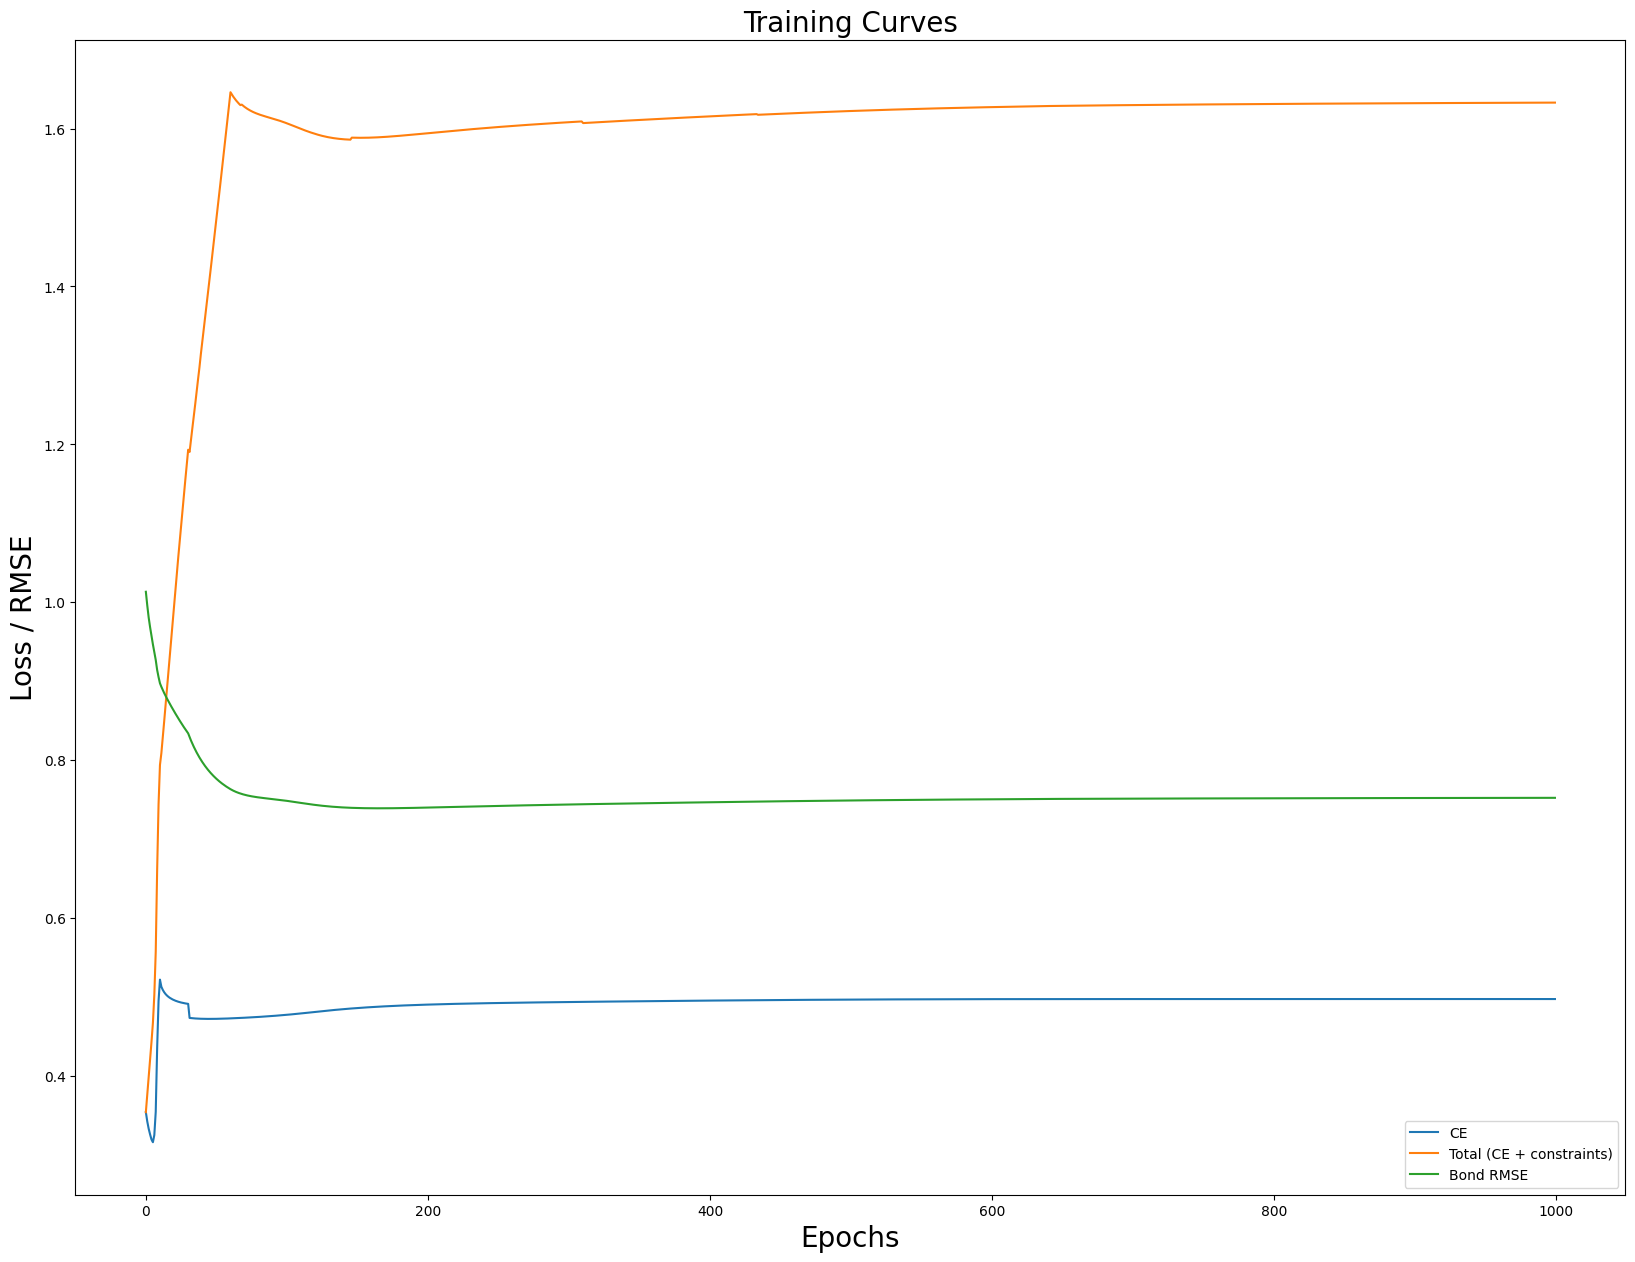

In [10]:
lr = 0.02
epochs = 1000

# ====== 训练前的准备 ======
lambda_b = 2.0
lambda_r = 0.5
repulsion_cutoff = 1.2  # Å
exclude_hop_le = 2
EE_epochs = 10
EE_factor = 10.0
max_grad_norm = 5.0

# —— 建议：把 H==1/2 的正样本在 CE 中加权（不改函数名，通过放大 P 实现）
w_bond = 1.0   # 对 hop=1 的额外权重（放到 P 上）
w_13   = 0.5   # 对 hop=2 的额外权重

# —— 两阶段/暖启动 & 学习率调度（超稳）
warm_b = 60    # 键长 60 步拉满
warm_r = 120   # 排斥 120 步拉满
lr_drop_pts = {EE_epochs, int(0.6 * epochs)}  # 在这些点把 lr×0.7
max_step_mani = 0.20   # 每步最大“流形”位移（Å）
max_step_phys = 0.10   # 每步最大“物理”位移（Å）

bond_targets = estimate_bond_targets_etkdg(mol)
H = hop_matrix(mol, kmax=exclude_hop_le + 1)

output_dir = "frames_new"; os.makedirs(output_dir, exist_ok=True)

CE_array, loss_total_array, bond_rmse_array = [], [], []
MIN_DIST = 0.5  # 下面会自适应微调

for i in range(epochs):

    # —— 平滑 EE 权重
    w_ee = ee_weight(i, EE_epochs, EE_factor)

    # —— 在 CE 中给 hop=1/2 更大权（通过放大 P 的正项，不改 ce_and_grad）
    P_eff_base = np.clip(P * w_ee, 0.0, 0.99)
    P_eff = P_eff_base * (1.0 + w_bond * (H == 1) + w_13 * (H == 2))
    P_eff = np.clip(P_eff, 0.0, 0.99)  # 限幅防饱和

    # —— 1) 流形主导步（先只用 CE 更新）
    CE_current, g_ce = ce_and_grad(P_eff, Y, a, b)
    CE_array.append(CE_current)

    # 位移裁剪 + 更新
    disp_mani = clip_disp(-lr * g_ce, max_step_mani)
    Y = Y + disp_mani
    Y = center_and_rescale(Y)

    # —— 2) 物理微调步（护栏，小步）
    g_bond = bond_spring_grad(Y, mol, bond_targets)
    g_rep  = repulsion_grad(Y, H, cutoff=repulsion_cutoff, exclude_hop_le=exclude_hop_le)
    lam_b = lambda_b * min(1.0, i / max(1, warm_b))   # 暖启动
    lam_r = lambda_r * min(1.0, i / max(1, warm_r))

    g_phys = lam_b * g_bond + lam_r * g_rep
    # 梯度裁剪（整体）+ 位移裁剪（逐原子）
    gn = np.linalg.norm(g_phys)
    if gn > max_grad_norm:
        g_phys *= (max_grad_norm / (gn + 1e-12))
    disp_phys = clip_disp(-lr * g_phys, max_step_phys)
    Y = Y + disp_phys
    Y = center_and_rescale(Y)

    # —— 学习率小幅退火（在关键点降温）
    if i in lr_drop_pts:
        lr *= 0.7

    # —— 每隔 30 步自适应一次 min_dist → 重新拟合 a,b（让 CE 曲线“贴合”当前几何）
    if (i % 30 == 0) and (i > 0):
        Dcur = euclidean_distances(Y, Y)
        posD = Dcur[P > 0]
        if posD.size > 0:
            target_cover = 0.60
            new_min = float(np.clip(np.quantile(posD, target_cover), 0.35, 0.60))
            if abs(new_min - MIN_DIST) > 0.02:
                MIN_DIST = new_min
                a, b = find_ab_params(MIN_DIST)
                print(f"[{i:04d}] adapt MIN_DIST→{MIN_DIST:.3f}, a={a:.3f}, b={b:.3f}")

    # —— 监控（沿用你的实现）
    lb  = float(bond_spring_loss(Y, mol, targets=bond_targets))
    lrp = float(repulsion_loss(Y, mol, cutoff=repulsion_cutoff, exclude_hop_le=exclude_hop_le))
    loss_total = CE_current + lam_b * lb + lam_r * lrp
    loss_total_array.append(loss_total)
    bond_rmse_array.append(np.sqrt(lb))

    if i % 10 == 0:
        frame_path = os.path.join(output_dir, f"frame_{i:04d}")
        print(f"[{i:04d}] CE={CE_current:.4f} | bondRMSE={np.sqrt(lb):.3f} | rep={lrp:.4f} | "
              f"lam_b={lam_b:.2f} lam_r={lam_r:.2f} | total={loss_total:.4f}")
        visualize_and_save_frame(smiles, Y, frame_path)
        render_html_to_image(frame_path + ".html", frame_path + ".png")

# —— 绘图不变
plt.figure(figsize=(20, 15))
plt.plot(CE_array, label="CE")
plt.plot(loss_total_array, label="Total (CE + constraints)")
plt.plot(bond_rmse_array, label="Bond RMSE")
plt.title("Training Curves", fontsize=20)
plt.xlabel("Epochs", fontsize=20); plt.ylabel("Loss / RMSE", fontsize=20)
plt.legend(); plt.show()


In [11]:
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
from vis import make_video_from_frames
make_video_from_frames("frames_new", "optimization_new.mp4", fps=10)

In [13]:
from IPython.display import Video
# 直接播放当前目录下的视频
Video("optimization_new.mp4", embed=True, width=600, height=400)

In [14]:
from moviepy.editor import VideoFileClip
from PIL import Image

# 修复 ANTIALIAS 的兼容性
if not hasattr(Image, 'ANTIALIAS'):
    Image.ANTIALIAS = Image.Resampling.LANCZOS

# 转换视频
clip = VideoFileClip("optimization_new.mp4").subclip(0, 5)  # 裁剪前5秒
clip = clip.resize(height=300)  # 缩小尺寸
clip.write_gif("optimization_new.gif", fps=10)  # 保存为GIF

MoviePy - Building file optimization_new.gif with imageio.
